Simple implementation in python 

From the paper:
Fast nonconvex deconvolution of calcium imaging data.
Jewell, S. W., Hocking, T. D., Fearnhead, P., & Witten, D. M. Biostatistics (2019)

See https://jewellsean.github.io/fast-spike-deconvolution/index.html#jewell2018fast 

Implementation ideas taken from https://github.com/kesward/FOCuS

In [1]:
import numpy as np
import portion as p
import matplotlib.pyplot as plt
from math import inf
from numpy.random import RandomState

In [2]:
class Quadratic:
    def __init__(self, a, b, c, tau, D):
        self.a = a
        self.b = b
        self.c = c
        self.tau = tau
        self.set = D
        
    def update(self, x):
        self.a += 0.5
        self.b -= x
        self.c += 0.5 * x**2

    def reparam(self, gamma):
        return Quadratic(self.a/(gamma**2), self.b/gamma, self.c, self.tau, self.set)
        
    def roots(self, z):
        disc = self.b**2 - 4*self.a*(self.c-z)
        if disc < 0:
            return p.empty()
        x1 = (-self.b + np.sqrt(disc))/(2*self.a)
        x2 = (-self.b - np.sqrt(disc))/(2*self.a)
        return p.closed(min(x1,x2), max(x1,x2))
    
    def min(self):
        # check if constant func
        if self.a == 0 and self.b == 0:
            return self.c
        # check if argmin of quad within set its defined on
        elif -self.b/(2*self.a) in self.set:
            return -(self.b**2)/(4*self.a) + self.c
        # iterate through intervals that make up set and find min on each
        else:
            currmin = inf
            for ival in self.set:
                if ival.upper < -self.b/(2*self.a):
                    currmin = min(currmin, self.a*(ival.upper)**2 + self.b*ival.upper + self.c)
                else:
                    currmin = min(currmin, self.a*(ival.lower)**2 + self.b*ival.lower + self.c)
            return currmin
            
    def __repr__(self):
        return f'Quadratic: {self.a}x^2 + {self.b}x + {self.c}, tau = {self.tau}, set = {self.set}'

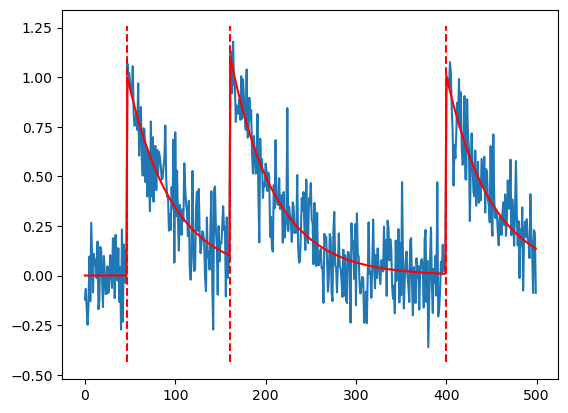

In [3]:
# sim data - from FastLZeroSpikeInference R package
def simulate_ar1(n, gam, poisMean, sd, seed):
    if seed is None:
        prng = RandomState()
    else:
        prng = RandomState(seed)
    eta = [0]*n
    c = [0]*n
    f = [0]*n
    for i in range(n):
        eta[i] = prng.poisson(poisMean)
        if i > 0:
            c[i] = gam * c[i-1] + eta[i]
        else:
            c[i] = eta[i]
        f[i] = c[i] + prng.normal(scale = sd)
    spikesOut = np.where(np.array(eta) > 0)[0].tolist()
    return {'spikes': spikesOut, 'fl': f, 'conc': c}

sim = simulate_ar1(n=500, gam=0.98, poisMean=0.01, sd=0.15, seed=1)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(sim['fl'])
ax.plot(sim['conc'], color = 'red')
ymin, ymax = ax.get_ylim()
ax.vlines(sim['spikes'], linestyles='dashed', colors = 'red', ymin = ymin, ymax = ymax)

In [4]:
# initialise 
y = sim['fl']
n = len(y)
lda = 0.5
gamma = 0.98
D = p.closedopen(0, inf)
cost_list_record = [None]*n

cost_list = [Quadratic(0.5, -1*y[0], 0.5*y[0]**2, 0, D)]
cost_list_record[0] = cost_list

In [5]:
for t in range(1, n):

    min_alphaprime = min([q.min() for q in cost_list]) + lda
    new_cost_list = []
    newseg_set = p.empty()
    for q in cost_list:
        # carry on segment
        q_reparam = q.reparam(gamma)
        minset = q_reparam.roots(min_alphaprime)
        minset_int = q_reparam.set.intersection(minset)
        if not minset_int.empty:
            q_reparam.set = minset
            newseg_set = newseg_set.union(minset)
            q_reparam.update(y[t])
            new_cost_list.append(q_reparam)

    # new segment 
    newseg = Quadratic(0, 0, min_alphaprime, t, D.difference(newseg_set))
    newseg.update(y[t])
    new_cost_list.append(newseg)
    cost_list = new_cost_list
    cost_list_record[t] = cost_list

In [6]:
tau_curr = n
while tau_curr > 0:
    tau_prev = tau_curr
    tau_curr, _ = min([(cost.tau, cost.min()) for cost in cost_list_record[(tau_curr-1)]], key = lambda t: t[1])
    print(tau_curr)

400
161
47
0
